In [551]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import requests
import os
import datetime as dt
from datetime import timedelta, date

In [552]:
df_1 = pd.read_csv('Data/Oct_Dec_2022_Lethbridge_Police_Service_report.csv')
df_2 = pd.read_csv('Data/Jan_Mar_2023_Lethbridge_Police_Service_report.csv')
df_3 = pd.read_csv('Data/Apr_Jun_2023_Lethbridge_Police_Service_report.csv')

df = pd.concat([df_1, df_2, df_3])
df = df.drop_duplicates()
df.head()

,ccn,date,updateDate,city,state,postalCode,blocksizedAddress,incidentType,parentIncidentType,narrative
0,CA23018227,"12/25/2022, 12:00:00 AM","08/03/2023, 1:23:51 PM",LETHBRIDGE,AB,.,1600 Block ST GEORGE RD,RMS] Assault,Assault,Assault
1,CA23016523,"12/01/2022, 9:04:00 AM","08/03/2023, 8:23:45 AM",LETHBRIDGE,AB,T1J 5J4,100 Block GOLDENROD RD,RMS] Fraud - Identity Fraud,Other,Fraud - Identity Fraud
2,RM23054146,"10/21/2022, 4:00:00 PM","07/22/2023, 8:39:56 AM",LETHBRIDGE,AB,.,100 Block FAIRMONT BD,RMS] Proceeds Of Crime Criminal Cod,Other,Proceeds Of Crime Criminal Cod
3,CA23008687,"11/01/2022, 7:00:00 AM","07/06/2023, 9:00:30 AM",LETHBRIDGE,AB,.,1 Block BLACKFOOT CI,RMS] Sexual Assault,Sexual Offense,Sexual Assault
4,RM22058254,"12/16/2022, 1:00:00 PM","07/06/2023, 9:00:20 AM",LETHBRIDGE,AB,.,100 Block 1 AV,RMS] Assist Others,Other,Assist Others


In [553]:
df.describe()

,ccn,date,updateDate,city,state,postalCode,blocksizedAddress,incidentType,parentIncidentType,narrative
count,68538,68538,68538,68538,68538,68538,68526,68538,68538,68538
unique,68538,65515,14349,31,3,226,2990,536,13,289
top,CA23018227,"02/01/2023, 3:00:00 PM","11/24/2022, 1:24:20 AM",LETHBRIDGE,AB,.,UNKNOWN STREET,PUBLIC SERVICE,Other,PUBLIC SERVICE
freq,1,17,60,68451,68535,67657,3691,5772,37446,5772


There are 31 unique values for the 'city' column, and there should only be 1 ('LETHBRIDGE').  Looking at the unique values we can see that there are some incidents that should not be included, and 1 with a typo ('LETHBRIDE').

In [554]:
df['city'].value_counts()

city
LETHBRIDGE           68451
COALDALE                15
LETHBRIDGE COUNTY       14
COALHURST                8
FORT MACLEOD             8
CALGARY                  5
TABER                    4
CARDSTON                 4
RAYMOND                  3
FAIRVIEW                 3
PINCHER CREEK            2
STAND OFF                2
BELLEVUE                 1
DR                       1
BARONS                   1
COUNTY LETHBRIDGE        1
WETASKIWIN               1
OTTAWA                   1
LAVAL                    1
BROOKS                   1
THREE HILLS              1
RED DEER                 1
SAINT-LAURENT            1
Lethbridge               1
EDMONTON                 1
RED CLIFF                1
CLARESHOLM               1
MAGRATH                  1
STIRLING                 1
LETHBRIDE                1
NOBLEFORD                1
Name: count, dtype: int64

In [555]:
# Fixing typos and dropping any rows where the city is not 'LETHBRIDGE'
df = df.replace('LETHBRIDE', 'LETHBRIDGE')
df = df[df['city'] == 'LETHBRIDGE']

In [556]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68452 entries, 0 to 24689
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ccn                 68452 non-null  object
 1   date                68452 non-null  object
 2   updateDate          68452 non-null  object
 3   city                68452 non-null  object
 4   state               68452 non-null  object
 5   postalCode          68452 non-null  object
 6   blocksizedAddress   68446 non-null  object
 7   incidentType        68452 non-null  object
 8   parentIncidentType  68452 non-null  object
 9   narrative           68452 non-null  object
dtypes: object(10)
memory usage: 5.7+ MB


There are some null values in the 'blocksizedAddress' column, let's remove these

In [557]:
df = df.dropna(subset=['blocksizedAddress'], axis=0)

Let's look at the values in the 'parentIncidentType' column

In [558]:
df['parentIncidentType'].value_counts()

parentIncidentType
Other                  37376
Quality of Life         9761
Proactive Policing      9408
Traffic                 4143
Theft                   3198
Assault                 1664
Theft from Vehicle      1437
Property Crime           677
Sexual Offense           447
Theft of Vehicle         244
Robbery                   79
Breaking & Entering       10
Homicide                   2
Name: count, dtype: int64

Let's remove all 'Proactive Policing' and 'Traffic' incidents, as we only want crimes reported by the public.  'Proactive Policing' and 'Traffic' incidents are usually only registered when witnessed by police.  There may be 'Traffic" incidents that are reported by the public, but we'll assume that this is a very small number.

In [559]:
df = df[~df['parentIncidentType'].isin(['Proactive Policing', 'Traffic'])]
df.describe()

,ccn,date,updateDate,city,state,postalCode,blocksizedAddress,incidentType,parentIncidentType,narrative
count,54895,54895,54895,54895,54895,54895,54895,54895,54895,54895
unique,54895,52300,13396,1,1,82,2469,500,11,276
top,CA23018227,"02/01/2023, 3:00:00 PM","11/24/2022, 1:24:18 AM",LETHBRIDGE,AB,.,100 Block 1 AV,PUBLIC SERVICE,Other,PUBLIC SERVICE
freq,1,17,54,54895,54895,54586,2193,5772,37376,5772


We don't need the 'updateDate', 'incidentType' or 'postalCode' columns so let's drop them

In [560]:
df = df.drop(['updateDate','incidentType', 'postalCode'], axis=1)

Most of the values in the 'blocksizedAddress' refer to a city block, which is what we want. However some refer to a street corner and others are 'UNKNOWN STREET'.  Let's drop these ones for the sake of simplicity.

In [561]:
df = df[df['blocksizedAddress'].str.contains('Block')]

Now we'll make a new column for the full address

In [562]:
df['address'] = df['blocksizedAddress'].str.replace('Block ', '') + ', ' + df['city'] + ', ' + df['state'] + ', Canada'
df[['address']]

,address
0,"1600 ST GEORGE RD, LETHBRIDGE, AB, Canada"
1,"100 GOLDENROD RD, LETHBRIDGE, AB, Canada"
2,"100 FAIRMONT BD, LETHBRIDGE, AB, Canada"
3,"1 BLACKFOOT CI, LETHBRIDGE, AB, Canada"
4,"100 1 AV, LETHBRIDGE, AB, Canada"
...,...
24682,"300 8 ST, LETHBRIDGE, AB, Canada"
24683,"1 LAFAYETTE BD, LETHBRIDGE, AB, Canada"
24687,"800 2A AV, LETHBRIDGE, AB, Canada"
24688,"100 LAVAL BD, LETHBRIDGE, AB, Canada"


The longitude and latitude of each address was found in the 'Google Geocoding API' notebook. We'll import a dataframe of all unique addresses with their coordinates and indicent count here.

In [563]:
df_address

,address,lat,lng,incidentCount,incidentCummSum
0,"100 1 AV, LETHBRIDGE, AB, Canada",49.697816,-112.840058,2193,0.041910
1,"800 2A AV, LETHBRIDGE, AB, Canada",49.701727,-112.831368,1361,0.067919
2,"800 5 AV, LETHBRIDGE, AB, Canada",49.692594,-112.834855,925,0.085596
3,"500 1 AV, LETHBRIDGE, AB, Canada",49.697940,-112.840158,864,0.102108
4,"600 8 ST, LETHBRIDGE, AB, Canada",49.690751,-112.835657,832,0.118008
...,...,...,...,...,...
2059,"1 AVENUE, LETHBRIDGE, AB, Canada",49.698021,-112.838530,1,0.996369
2058,"1 AVE & MAYOR MAGRATH DRIVE DR, LETHBRIDGE, AB...",49.679095,-112.802481,1,0.996350
2057,"1 AVE & CROWSNEST TR, LETHBRIDGE, AB, Canada",49.698350,-112.783758,1,0.996331
2056,"1 AVE & 6 AVE, LETHBRIDGE, AB, Canada",49.697549,-112.777943,1,0.996312


In [564]:
df_address = pd.read_csv('df_address.csv')
df_address = df_address[df_address['address'].isin(df['address'])]

In [565]:
df_address[df_address['lat']>50]

,address,lat,lng,incidentCount


Now we add the coordinates to the incidents dataframe

In [566]:
df = df.merge(df_address.drop('incidentCount', axis=1), on='address', how='left')

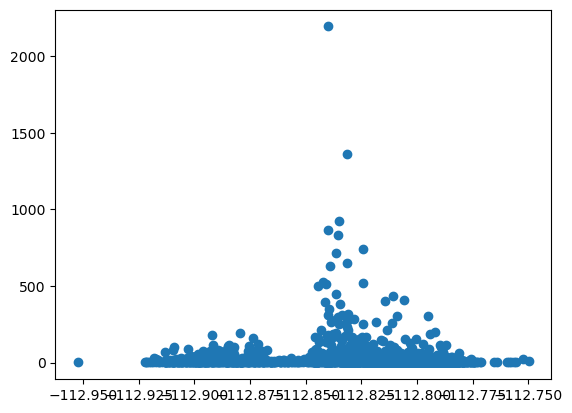

In [567]:
plt.scatter(df_address['lng'], df_address['incidentCount'])

# Creating Block-Hour DataFrame

Now we need to make a dataframe where each row is a unique 'block-hour'.  Let's start by converting date strings to datetimes.

In [568]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

/var/folders/t5/t3vd2l292dz2vlb6dq_km0fh0000gn/T/ipykernel_90810/63736465.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
/var/folders/t5/t3vd2l292dz2vlb6dq_km0fh0000gn/T/ipykernel_90810/63736465.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)


In [569]:
"""

df_incidents = df.drop(['ccn', 'city', 'state', 'blocksizedAddress', 'narrative', 'parentIncidentType'], axis=1)

conditions = [
    df_blockDay['date'].dt.hour,
    df_blockDay['date'].dt.month.isin([3,4,5]),
    df_blockDay['date'].dt.month.isin([6,7,8]),
    df_blockDay['date'].dt.month.isin([9,10,11])
    ]

choices = [
    'winter',
    'spring',
    'summer',
    'fall'
    ]

df_blockDay.insert(2, 'season', np.select(conditions,choices,default='?'))

"""

"\n\ndf_incidents = df.drop(['ccn', 'city', 'state', 'blocksizedAddress', 'narrative', 'parentIncidentType'], axis=1)\n\nconditions = [\n    df_blockDay['date'].dt.hour,\n    df_blockDay['date'].dt.month.isin([3,4,5]),\n    df_blockDay['date'].dt.month.isin([6,7,8]),\n    df_blockDay['date'].dt.month.isin([9,10,11])\n    ]\n\nchoices = [\n    'winter',\n    'spring',\n    'summer',\n    'fall'\n    ]\n\ndf_blockDay.insert(2, 'season', np.select(conditions,choices,default='?'))\n\n"

In [570]:
df_incidentBlockDate = df_incidents.pivot_table(index=['address', df_incidents['date'].dt.date], values='lat', aggfunc='count').reset_index()
df_incidentBlockDate.columns = ['address','date','incidentCount']
df_incidentBlockDate['date'] = pd.to_datetime(df_incidentBlockDate['date'])

In [571]:
df_incidentBlockDate

,address,date,incidentCount
0,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-12,2
1,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-14,1
2,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-17,1
3,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-31,1
4,"1 1 AV, LETHBRIDGE, AB, Canada",2022-11-02,1
...,...,...,...
27621,"900 STAFFORD DR, LETHBRIDGE, AB, Canada",2023-04-26,1
27622,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2022-11-24,1
27623,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-01-15,1
27624,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-01-21,2


In [572]:
df_address

,address,lat,lng,incidentCount
0,"100 1 AV, LETHBRIDGE, AB, Canada",49.697816,-112.840058,2193
1,"800 2A AV, LETHBRIDGE, AB, Canada",49.701727,-112.831368,1361
2,"800 5 AV, LETHBRIDGE, AB, Canada",49.692594,-112.834855,925
3,"500 1 AV, LETHBRIDGE, AB, Canada",49.697940,-112.840158,864
4,"600 8 ST, LETHBRIDGE, AB, Canada",49.690751,-112.835657,832
...,...,...,...,...
2274,"2300 7 AV, LETHBRIDGE, AB, Canada",49.688964,-112.808976,1
2275,"2400 11 AV, LETHBRIDGE, AB, Canada",49.681863,-112.807164,1
2276,"2400 17 AV, LETHBRIDGE, AB, Canada",49.675228,-112.806886,1
2277,"2400 2A AV, LETHBRIDGE, AB, Canada",49.701727,-112.831368,1


In [573]:
# Creating a dataframe that has a row for every combination of address (block) and date

date_min = df['date'].min().date()
date_max = df['date'].max().date() + timedelta(days=1)

addresses = df_address['address']
dates = pd.date_range(start=date_min, end=date_max)
time_interval = ['00:00-06:00', '06:00-12:00', '12:00-18:00', '18:00-24:00']

df_blockDay = pd.DataFrame([(a,d) for a in addresses for d in dates])
df_blockDay.columns = ['address', 'date']
df_blockDay = df_blockDay.merge(df_incidentBlockDate, on=['address','date'], how='left').fillna(0)

df_blockDay = df_blockDay.merge(df_address.drop('incidentCount',axis=1), on='address', how='left')


df_blockDay.insert(5, 'incidentOccured?', (df_blockDay['incidentCount'] > 0)*1)

df_blockDay.head(16)

,address,date,incidentCount,lat,lng,incidentOccured?
0,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-01,1.0,49.697816,-112.840058,1
1,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-02,3.0,49.697816,-112.840058,1
2,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-03,8.0,49.697816,-112.840058,1
3,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-04,17.0,49.697816,-112.840058,1
4,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-05,20.0,49.697816,-112.840058,1
5,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-06,19.0,49.697816,-112.840058,1
6,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-07,1.0,49.697816,-112.840058,1
7,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-08,2.0,49.697816,-112.840058,1
8,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-09,1.0,49.697816,-112.840058,1
9,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-10,3.0,49.697816,-112.840058,1


In [574]:
df_blockDay['date']

0        2022-10-01
1        2022-10-02
2        2022-10-03
3        2022-10-04
4        2022-10-05
            ...    
611870   2023-06-28
611871   2023-06-29
611872   2023-06-30
611873   2023-07-01
611874   2023-07-02
Name: date, Length: 611875, dtype: datetime64[ns]

In [575]:
df_timeseries = df_blockDay.pivot_table(index='date', values='incidentCount', aggfunc='sum').reset_index()
df_timeseries

,date,incidentCount
0,2022-10-01,138.0
1,2022-10-02,219.0
2,2022-10-03,224.0
3,2022-10-04,202.0
4,2022-10-05,224.0
...,...,...
270,2023-06-28,212.0
271,2023-06-29,194.0
272,2023-06-30,225.0
273,2023-07-01,85.0


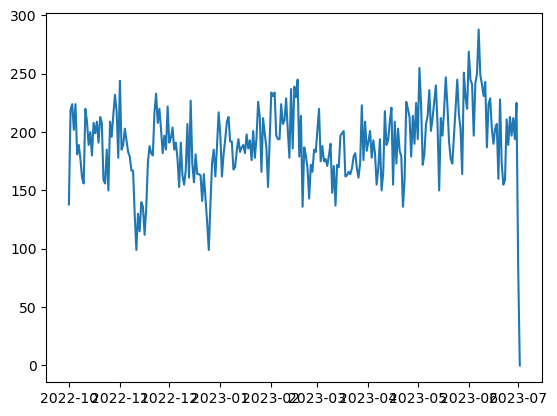

In [576]:
plt.plot(df_timeseries['date'],df_timeseries['incidentCount'])

In [577]:
df_blockDay['incidentOccured?'].value_counts()

incidentOccured?
0    584249
1     27626
Name: count, dtype: int64

In [578]:
df_blockDay

,address,date,incidentCount,lat,lng,incidentOccured?
0,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-01,1.0,49.697816,-112.840058,1
1,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-02,3.0,49.697816,-112.840058,1
2,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-03,8.0,49.697816,-112.840058,1
3,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-04,17.0,49.697816,-112.840058,1
4,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-05,20.0,49.697816,-112.840058,1
...,...,...,...,...,...,...
611870,"2400 5 AV, LETHBRIDGE, AB, Canada",2023-06-28,0.0,49.693458,-112.807515,0
611871,"2400 5 AV, LETHBRIDGE, AB, Canada",2023-06-29,0.0,49.693458,-112.807515,0
611872,"2400 5 AV, LETHBRIDGE, AB, Canada",2023-06-30,0.0,49.693458,-112.807515,0
611873,"2400 5 AV, LETHBRIDGE, AB, Canada",2023-07-01,0.0,49.693458,-112.807515,0


In [579]:
df[df['date'].dt.date==date(2022,10,5)]

,ccn,date,city,state,blocksizedAddress,parentIncidentType,narrative,address,lat,lng
68,CA22022522,2022-10-05 15:00:00,LETHBRIDGE,AB,1800 Block 23 ST,Other,Check On Welfare,"1800 23 ST, LETHBRIDGE, AB, Canada",49.720937,-112.810393
410,CA22022053,2022-10-05 06:16:00,LETHBRIDGE,AB,2300 Block 13 ST,Theft from Vehicle,Theft From Auto Under,"2300 13 ST, LETHBRIDGE, AB, Canada",49.725008,-112.825161
4663,AR22100771,2022-10-05 23:04:00,LETHBRIDGE,AB,1 Block HERITAGE BD,Theft from Vehicle,Mischief to MV,"1 HERITAGE BD, LETHBRIDGE, AB, Canada",49.693513,-112.888448
11149,CA22022099,2022-10-05 17:12:00,LETHBRIDGE,AB,1 Block PARK MEADOWS BD,Other,Check On Welfare,"1 PARK MEADOWS BD, LETHBRIDGE, AB, Canada",49.721026,-112.810262
12517,CA22022040,2022-10-05 03:51:00,LETHBRIDGE,AB,1100 Block 27 ST,Other,Landlord & Tenant,"1100 27 ST, LETHBRIDGE, AB, Canada",49.681706,-112.802900
...,...,...,...,...,...,...,...,...,...,...
15942,P22047143,2022-10-05 01:53:25,LETHBRIDGE,AB,500 Block STAFFORD DR,Quality of Life,DISTURBANCE/NUISANCE,"500 STAFFORD DR, LETHBRIDGE, AB, Canada",49.705223,-112.833880
15943,P22047144,2022-10-05 01:54:15,LETHBRIDGE,AB,500 Block 21 ST,Other,"PUBLIC SERVICE (LOCK-OUT/LOCK-IN, PEACE, WELFA...","500 21 ST, LETHBRIDGE, AB, Canada",49.693111,-112.811428
15947,P22047130,2022-10-05 00:03:29,LETHBRIDGE,AB,200 Block 4 AV,Other,SUPPLEMENTAL,"200 4 AV, LETHBRIDGE, AB, Canada",49.693695,-112.841379
15948,P22047132,2022-10-05 00:17:26,LETHBRIDGE,AB,600 Block 8 ST,Sexual Offense,SEXUAL ASSAULT,"600 8 ST, LETHBRIDGE, AB, Canada",49.690751,-112.835657


In [580]:
df[(df['address']=='100 1 AV, LETHBRIDGE, AB, Canada') &
(df['date'].dt.date==date(2022,10,5))]

,ccn,date,city,state,blocksizedAddress,parentIncidentType,narrative,address,lat,lng
14183,RM22056842,2022-10-05 07:00:00,LETHBRIDGE,AB,100 Block 1 AV,Other,Assist Others,"100 1 AV, LETHBRIDGE, AB, Canada",49.697816,-112.840058
15461,RM22056644,2022-10-05 15:00:00,LETHBRIDGE,AB,100 Block 1 AV,Other,Fail to Appear Finger Prints,"100 1 AV, LETHBRIDGE, AB, Canada",49.697816,-112.840058
15622,RM22056618,2022-10-05 15:00:00,LETHBRIDGE,AB,100 Block 1 AV,Other,Fail to Appear Finger Prints,"100 1 AV, LETHBRIDGE, AB, Canada",49.697816,-112.840058
15623,RM22056617,2022-10-05 15:00:00,LETHBRIDGE,AB,100 Block 1 AV,Other,Fail to Appear Finger Prints,"100 1 AV, LETHBRIDGE, AB, Canada",49.697816,-112.840058
15650,RM22056610,2022-10-05 15:00:00,LETHBRIDGE,AB,100 Block 1 AV,Other,Fail to Appear Finger Prints,"100 1 AV, LETHBRIDGE, AB, Canada",49.697816,-112.840058
15657,RM22056608,2022-10-05 15:00:00,LETHBRIDGE,AB,100 Block 1 AV,Other,Fail to Appear Finger Prints,"100 1 AV, LETHBRIDGE, AB, Canada",49.697816,-112.840058
15658,RM22056606,2022-10-05 15:00:00,LETHBRIDGE,AB,100 Block 1 AV,Other,Fail to Appear Finger Prints,"100 1 AV, LETHBRIDGE, AB, Canada",49.697816,-112.840058
15659,RM22056605,2022-10-05 15:00:00,LETHBRIDGE,AB,100 Block 1 AV,Other,Fail to Appear Finger Prints,"100 1 AV, LETHBRIDGE, AB, Canada",49.697816,-112.840058
15664,RM22056604,2022-10-05 15:00:00,LETHBRIDGE,AB,100 Block 1 AV,Other,Fail to Appear Finger Prints,"100 1 AV, LETHBRIDGE, AB, Canada",49.697816,-112.840058
15787,RM22056598,2022-10-05 20:00:00,LETHBRIDGE,AB,100 Block 1 AV,Other,Mental Health Act,"100 1 AV, LETHBRIDGE, AB, Canada",49.697816,-112.840058


In [581]:
df_blockDay#.drop_duplicates()

,address,date,incidentCount,lat,lng,incidentOccured?
0,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-01,1.0,49.697816,-112.840058,1
1,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-02,3.0,49.697816,-112.840058,1
2,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-03,8.0,49.697816,-112.840058,1
3,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-04,17.0,49.697816,-112.840058,1
4,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-05,20.0,49.697816,-112.840058,1
...,...,...,...,...,...,...
611870,"2400 5 AV, LETHBRIDGE, AB, Canada",2023-06-28,0.0,49.693458,-112.807515,0
611871,"2400 5 AV, LETHBRIDGE, AB, Canada",2023-06-29,0.0,49.693458,-112.807515,0
611872,"2400 5 AV, LETHBRIDGE, AB, Canada",2023-06-30,0.0,49.693458,-112.807515,0
611873,"2400 5 AV, LETHBRIDGE, AB, Canada",2023-07-01,0.0,49.693458,-112.807515,0


In [582]:
df_blockDay['date']

0        2022-10-01
1        2022-10-02
2        2022-10-03
3        2022-10-04
4        2022-10-05
            ...    
611870   2023-06-28
611871   2023-06-29
611872   2023-06-30
611873   2023-07-01
611874   2023-07-02
Name: date, Length: 611875, dtype: datetime64[ns]

In [583]:
df_blockDay['incidentOccured?'] = np.where(df_blockDay)

ValueError: Length of values (2) does not match length of index (611875)

In [ ]:
df_incidentBlockDate

,address,date,incidentCount
0,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-12,2
1,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-14,1
2,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-17,1
3,"1 1 AV, LETHBRIDGE, AB, Canada",2022-10-31,1
4,"1 1 AV, LETHBRIDGE, AB, Canada",2022-11-02,1
...,...,...,...
27621,"900 STAFFORD DR, LETHBRIDGE, AB, Canada",2023-04-26,1
27622,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2022-11-24,1
27623,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-01-15,1
27624,"900 VENTURA CR, LETHBRIDGE, AB, Canada",2023-01-21,2


In [ ]:
(8760/6)*4*2000

11680000.0

In [ ]:
date(2023,6,1)

datetime.date(2023, 6, 1)

In [ ]:
df_blockDay_training = df_blockDay[df_blockDay['date'].dt.date < date(2023,6,1)]
df_blockDay_test = df_blockDay[df_blockDay['date'].dt.date >= date(2023,6,1)]

In [ ]:
df_blockDay_training

,address,date,season,incidentCount,lat,lng,incidentOccured?
0,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-01,fall,1.0,49.697816,-112.840058,1
1,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-02,fall,3.0,49.697816,-112.840058,1
2,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-03,fall,8.0,49.697816,-112.840058,1
3,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-04,fall,17.0,49.697816,-112.840058,1
4,"100 1 AV, LETHBRIDGE, AB, Canada",2022-10-05,fall,20.0,49.697816,-112.840058,1
...,...,...,...,...,...,...,...
611838,"2400 5 AV, LETHBRIDGE, AB, Canada",2023-05-27,spring,0.0,49.693458,-112.807515,0
611839,"2400 5 AV, LETHBRIDGE, AB, Canada",2023-05-28,spring,0.0,49.693458,-112.807515,0
611840,"2400 5 AV, LETHBRIDGE, AB, Canada",2023-05-29,spring,0.0,49.693458,-112.807515,0
611841,"2400 5 AV, LETHBRIDGE, AB, Canada",2023-05-30,spring,0.0,49.693458,-112.807515,0


In [ ]:
df_address = df_address.sort_values('incidentCount',ascending = False)
df_address['incidentCummSum'] = np.cumsum(df_address['incidentCount'])/df_address['incidentCount'].sum()

In [ ]:
df_address[df_address['incidentCummSum'] < 0.50]

,address,lat,lng,incidentCount,incidentCummSum
0,"100 1 AV, LETHBRIDGE, AB, Canada",49.697816,-112.840058,2193,0.041910
1,"800 2A AV, LETHBRIDGE, AB, Canada",49.701727,-112.831368,1361,0.067919
2,"800 5 AV, LETHBRIDGE, AB, Canada",49.692594,-112.834855,925,0.085596
3,"500 1 AV, LETHBRIDGE, AB, Canada",49.697940,-112.840158,864,0.102108
4,"600 8 ST, LETHBRIDGE, AB, Canada",49.690751,-112.835657,832,0.118008
...,...,...,...,...,...
85,"1300 23 AV, LETHBRIDGE, AB, Canada",49.724552,-112.823450,105,0.491677
86,"100 ALGONQUIN RD, LETHBRIDGE, AB, Canada",49.681929,-112.882415,103,0.493646
87,"1700 23 ST, LETHBRIDGE, AB, Canada",49.719912,-112.811238,103,0.495614
88,"500 MAYOR MAGRATH DR, LETHBRIDGE, AB, Canada",49.693084,-112.810123,102,0.497563


In [ ]:
90/2225

0.04044943820224719

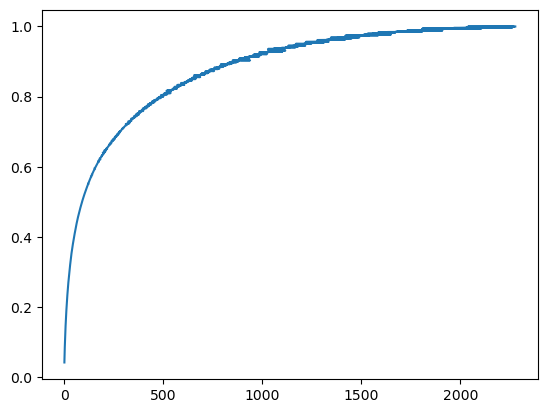

In [ ]:
plt.plot(df_address.index,df_address['incidentCummSum'])

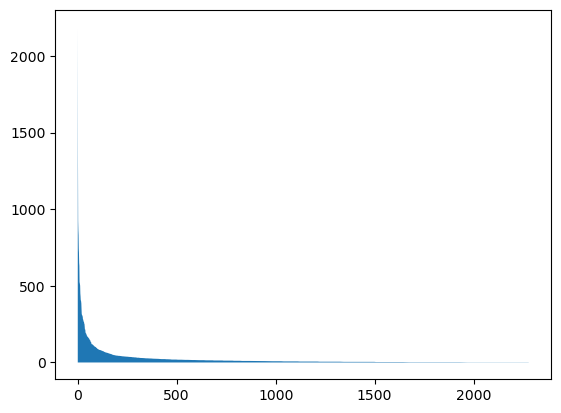

In [ ]:
plt.fill_between(df_address.index,df_address['incidentCount'])

## All-Time Hotspots

In [591]:
threshold = 0.50

df_hotspot = df_blockDay_training.pivot_table(index='address', values='incidentOccured?', aggfunc='mean').reset_index()
df_hotspot = df_hotspot.sort_values('incidentOccured?',ascending=False)
df_hotspot.columns = ['address','incidentChance']
df_hotspot = df_hotspot[df_hotspot['incidentChance']>=threshold]

In [592]:
df_blockDay_test['Hotspot Prediction'] = df_blockDay_test['address'].isin(df_hotspot['address'])*1

/var/folders/t5/t3vd2l292dz2vlb6dq_km0fh0000gn/T/ipykernel_90810/3288250573.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_blockDay_test['Hotspot Prediction'] = df_blockDay_test['address'].isin(df_hotspot['address'])*1


In [593]:
def print_confusion_matrix(y_test, y_pred):
    from sklearn.metrics import confusion_matrix
    cf = confusion_matrix(y_test, y_pred)
    plt.figure()
    sns.heatmap(cf, annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('Confusion Matrix')

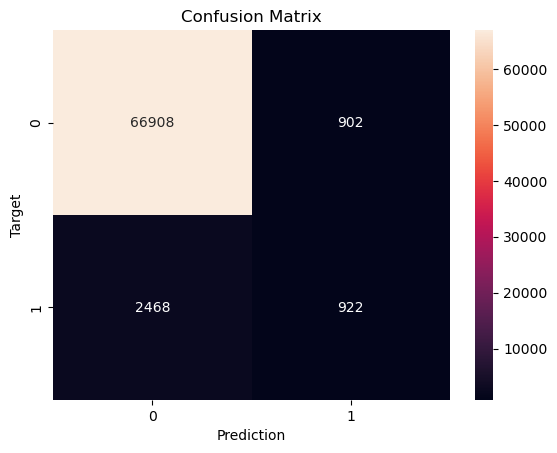

In [594]:
print_confusion_matrix(df_blockDay_test['incidentOccured?'], df_blockDay_test['Hotspot Prediction'])

In [595]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
print(classification_report(df_blockDay_test['incidentOccured?'], df_blockDay_test['Hotspot Prediction']))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     67810
           1       0.51      0.27      0.35      3390

    accuracy                           0.95     71200
   macro avg       0.73      0.63      0.66     71200
weighted avg       0.94      0.95      0.95     71200



In [518]:
df_blockDay_test[df_blockDay_test['Hotspot']==True]

,address,date,season,incidentCount,lat,lng,incidentOccured?,Hotspot
243,"100 1 AV, LETHBRIDGE, AB, Canada",2023-06-01,summer,10.0,49.697816,-112.840058,1,1
244,"100 1 AV, LETHBRIDGE, AB, Canada",2023-06-02,summer,5.0,49.697816,-112.840058,1,1
245,"100 1 AV, LETHBRIDGE, AB, Canada",2023-06-03,summer,4.0,49.697816,-112.840058,1,1
246,"100 1 AV, LETHBRIDGE, AB, Canada",2023-06-04,summer,3.0,49.697816,-112.840058,1,1
247,"100 1 AV, LETHBRIDGE, AB, Canada",2023-06-05,summer,16.0,49.697816,-112.840058,1,1
...,...,...,...,...,...,...,...,...
5495,"500 6 AV, LETHBRIDGE, AB, Canada",2023-06-28,summer,0.0,49.690704,-112.839558,0,1
5496,"500 6 AV, LETHBRIDGE, AB, Canada",2023-06-29,summer,4.0,49.690704,-112.839558,1,1
5497,"500 6 AV, LETHBRIDGE, AB, Canada",2023-06-30,summer,0.0,49.690704,-112.839558,0,1
5498,"500 6 AV, LETHBRIDGE, AB, Canada",2023-07-01,summer,0.0,49.690704,-112.839558,0,1


In [510]:
df_blockDay_test['Hotspot']

243       False
244       False
245       False
246       False
247       False
          ...  
611870    False
611871    False
611872    False
611873    False
611874    False
Name: Hotspot, Length: 71200, dtype: bool

In [484]:
df_blockDay_training.pivot_table(index='address',values=['incidentCount','incidentOccured?'],aggfunc='mean').reset_index().sort_values(by='incidentOccured?',ascending=False).head(20)

,address,incidentCount,incidentOccured?
391,"100 1 AV, LETHBRIDGE, AB, Canada",7.613169,0.987654
2143,"800 2A AV, LETHBRIDGE, AB, Canada",5.069959,0.946502
1088,"200 13 ST, LETHBRIDGE, AB, Canada",2.724280,0.917695
2149,"800 5 AV, LETHBRIDGE, AB, Canada",3.465021,0.917695
2035,"600 8 ST, LETHBRIDGE, AB, Canada",3.320988,0.851852
1852,"400 STAFFORD DR, LETHBRIDGE, AB, Canada",1.436214,0.835391
1915,"500 13 ST, LETHBRIDGE, AB, Canada",1.950617,0.835391
1907,"500 1 AV, LETHBRIDGE, AB, Canada",3.176955,0.835391
2093,"700 5 AV, LETHBRIDGE, AB, Canada",2.835391,0.794239
2094,"700 5 ST, LETHBRIDGE, AB, Canada",1.148148,0.790123
